In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import LineString
import tracers as tr
import numpy as np
import os
import json
import statistics

#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

[2025-03-09 17:54:03.095] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
[2025-03-09 17:54:05.394] [info] [network.cpp:172] Number of edges 203976 nodes 94384
[2025-03-09 17:54:05.394] [info] [network.cpp:173] Field index: id 19 source 0 target 1
[2025-03-09 17:54:05.547] [info] [network.cpp:176] Read network done.
Nodes 94384 edges 203976
[2025-03-09 17:54:05.549] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-09 17:54:05.580] [info] [network_graph.cpp:30] Graph nodes 94384 edges 203976
[2025-03-09 17:54:05.580] [info] [network_graph.cpp:31] Construct graph from network edges end


In [2]:
ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

[2025-03-09 17:54:05.593] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-09 17:54:06.754] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-09 17:54:07.752] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-09 17:54:08.638] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-09 17:54:09.472] [info] [ubodt.cpp:236] Read rows 4000000
[2025-03-09 17:54:10.285] [info] [ubodt.cpp:236] Read rows 5000000
[2025-03-09 17:54:11.211] [info] [ubodt.cpp:236] Read rows 6000000
[2025-03-09 17:54:12.174] [info] [ubodt.cpp:236] Read rows 7000000
[2025-03-09 17:54:13.071] [info] [ubodt.cpp:236] Read rows 8000000
[2025-03-09 17:54:14.000] [info] [ubodt.cpp:236] Read rows 9000000
[2025-03-09 17:54:15.012] [info] [ubodt.cpp:236] Read rows 10000000
[2025-03-09 17:54:15.920] [info] [ubodt.cpp:236] Read rows 11000000
[2025-03-09 17:54:16.746] [info] [ubodt.cpp:236] Read rows 12000000
[2025-03-09 17:54:17.652] [info] [ubodt.cpp:236] Read rows 13000000
[2025-0

In [ ]:
with open('datapath.json', 'r') as f:
    data = json.load(f)

root_path = data['data_path']

# these users wont give an empty mm result for the last 2000 points
valid_users_list = [4, 21, 24, 44, 70, 120, 144, 145, 153, 156, 167, 173, 183, 200, 201, 205, 220, 233, 245, 250, 264, 275, 283, 304, 306, 317, 353, 363, 371]

total_precision = []
total_recall = []
total_f1 = []
valid_users = 0

for user_id in valid_users_list:
    user_path = f'{user_id}.csv'
    file_path = os.path.join(root_path, user_path)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=",")
        df = df.rename(columns={"ID": "id", "Latitude": "x", "Longitude": "y", "Timestamp": "timestamp"})

        # Convert timestamp to epoch and sort by timestamp
        df["timestamp"] = pd.to_datetime(df["timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
        df["timestamp"] = df["timestamp"].astype(int)
        df = df.sort_values(by="timestamp")

        # Limit to first 2000 points 
        df = df.iloc[:2000]

        # Create wkt from lat lon data
        original_linestring = LineString(zip(df["y"], df["x"]))
        original_wkt = original_linestring.wkt
        model = FastMapMatch(network, graph, ubodt)

        # Configuration params
        k = 30
        radius = 400 / 100_000
        gps_error = 46 / 100_000

        fmm_config = FastMapMatchConfig(k, radius, gps_error, obfuscation=False, reverse_tolerance=10)

        # mm on the original trajectory 
        result = model.match_wkt(original_wkt, fmm_config)

        if result.cpath: 
            print(f"Map matching succeeded for user {user_id}") 
            gt = loads(result.mgeom.export_wkt())  

            # Apply perturbation
            (space_noise, time_min_period) = (110.0, 90)
            trace = df[['y', 'x', 'timestamp']].to_numpy()
            trace = [tuple(x) for x in trace]
            trace = [(x[0], x[1], int(x[2])) for x in trace]

            perturbed_traces = tr.perturb_traces((space_noise, time_min_period), [trace])
            perturbed_trace = perturbed_traces[0]

            df_pert = pd.DataFrame(perturbed_trace, columns=["y", "x", "timestamp"])
            df_pert["id"] = df["id"].iloc[0]

            perturbed_linestring = LineString(zip(df_pert["y"], df_pert["x"]))
            perturbed_wkt = perturbed_linestring.wkt

            obfuscation_stdev = 40 / 100_000

            fmm_config_pert = FastMapMatchConfig(k, radius, obfuscation_stdev, obfuscation=True, reverse_tolerance=10)
            result_pert = model.match_wkt(perturbed_wkt, fmm_config_pert)

            if result_pert.cpath: 
                perturbed_geom = loads(result_pert.mgeom.export_wkt())

                # Calculate intersection length between GT and perturbed matched result
                intersection = gt.intersection(perturbed_geom).length
                gt_length = gt.length
                mm_length = perturbed_geom.length

                # Calculate precision, recall, and F1 score
                precision = intersection / mm_length 
                recall = intersection / gt_length 
                f1 = (2 * precision * recall) / (precision + recall)

                print(f"user {user_id}, F1: {f1}")
                total_precision.append(precision)
                total_recall.append(recall)
                total_f1.append(f1)
                valid_users += 1

# precision, recall and f1
if valid_users > 0:
    med_precision = statistics.median(total_precision)  
    med_recall = statistics.median(total_recall)        
    med_f1 = statistics.median(total_f1)                
    print(f"Valid users: {valid_users}")
    print(f"Median Precision: {med_precision}")
    print(f"Median Recall: {med_recall}")
    print(f"Median F1 Score: {med_f1}")
else:
    print("map matching failed for all users")

Map matching succeeded for user 4
user 4, F1: 0.5387873053701435
Map matching succeeded for user 21
user 21, F1: 0.6275176797253121
Map matching succeeded for user 24
user 24, F1: 0.5814668517508231
Map matching succeeded for user 44
user 44, F1: 0.6373278856384703
Map matching succeeded for user 70
user 70, F1: 0.554745359026115
Map matching succeeded for user 120
user 120, F1: 0.4924382635319198
Map matching succeeded for user 144
user 144, F1: 0.47461698569477706
Map matching succeeded for user 145
user 145, F1: 0.6518320116633847
Map matching succeeded for user 153
user 153, F1: 0.5126194002478159
Map matching succeeded for user 156
user 156, F1: 0.6345123697861615
Map matching succeeded for user 167
user 167, F1: 0.47279261949981927
Map matching succeeded for user 173
user 173, F1: 0.5863857814996741
Map matching succeeded for user 183
user 183, F1: 0.5209785809335078
Map matching succeeded for user 200
user 200, F1: 0.5724360282907395
Map matching succeeded for user 201
user 201,

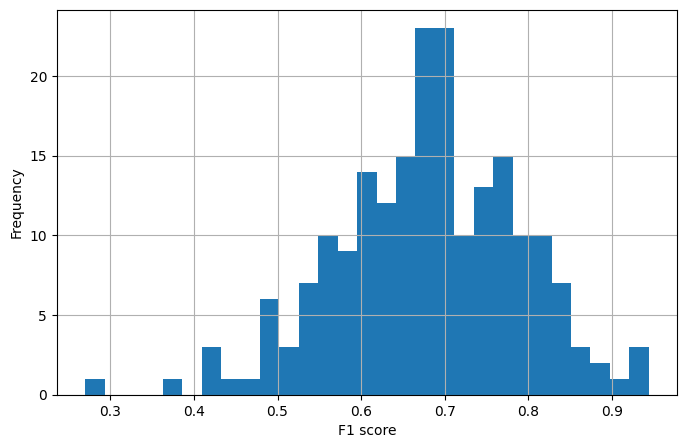

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(total_f1, bins=29)
plt.xlabel("Distribution of F1 scores of different users")  
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("F1 score")
plt.show()